In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import MLP model functions
from src.models.mlp_regressor import (
    load_engineered_data,
    prepare_data_for_modeling as prepare_data_regressor,
    scale_features,
    train_mlp_regressor,
    tune_mlp_regressor_hyperparams,
    evaluate_regressor,
    save_model as save_model_reg,
    save_scaler
)

from src.models.mlp_classifier import (
    train_mlp_classifier,
    tune_mlp_classifier_hyperparams,
    evaluate_classifier,
    save_model as save_model_clf,
    prepare_data_for_modeling as prepare_data_classifier
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Imports complete")

✓ Imports complete


In [23]:
# Reload external files
%load_ext autoreload
%autoreload 2

---
## Part 1: MLP Regressor - Continuous Delay Prediction
---

### 1.1 Load Engineered Data (Regression)

In [24]:
# Load the regression dataset (outliers removed)
input_path_reg = '../data/processed/flight_delays_engineered_regression.csv'
df_reg = load_engineered_data(input_path_reg)

print(f"\nDataset shape: {df_reg.shape}")
print(f"\nFirst few rows:")
df_reg.head()


Dataset shape: (1519602, 18)

First few rows:


,Date (YYYY-MM-DD),Scheduled Elapsed Time (Minutes),IsWeekend,Is_Holiday_Period,Carrier_9E,Carrier_AA,Carrier_AS,Carrier_DL,Carrier_EV,Carrier_MQ,Carrier_NK,Carrier_OO,Carrier_UA,Carrier_WN,Carrier_YX,Origin_Airport_Encoded,Season_Encoded,Arrival Delay (Minutes)
0,2019-01-01,83,0,1,1,0,0,0,0,0,0,0,0,0,0,67,3,-1
1,2019-01-01,72,0,1,1,0,0,0,0,0,0,0,0,0,0,163,3,-14
2,2019-01-01,85,0,1,1,0,0,0,0,0,0,0,0,0,0,86,3,9
3,2019-01-01,112,0,1,1,0,0,0,0,0,0,0,0,0,0,16,3,-7
4,2019-01-01,129,0,1,1,0,0,0,0,0,0,0,0,0,0,28,3,-32


In [25]:
# Define features for modeling
exclude_cols_reg = ['Date (YYYY-MM-DD)', 'Carrier Code', 'Origin Airport', 
                    'Season', 'Arrival Delay (Minutes)', 'Is_Delayed']

feature_cols_reg = [col for col in df_reg.columns if col not in exclude_cols_reg]

print(f"\nTotal features for regression: {len(feature_cols_reg)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols_reg, 1):
    print(f"  {i:2}. {col}")


Total features for regression: 16

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Carrier_DL
   8. Carrier_EV
   9. Carrier_MQ
  10. Carrier_NK
  11. Carrier_OO
  12. Carrier_UA
  13. Carrier_WN
  14. Carrier_YX
  15. Origin_Airport_Encoded
  16. Season_Encoded


### 1.2 Prepare Data & Scale Features (Regression)

In [26]:
# Split data
print("PREPARING DATA FOR MLP REGRESSOR")
print("="*60)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = prepare_data_regressor(
    df_reg, 
    feature_cols_reg, 
    'Arrival Delay (Minutes)',
    test_size=0.2,
    random_state=42
)

print(f"\nTarget statistics (Training):")
print(f"  Mean: {y_train_reg.mean():.2f} minutes")
print(f"  Std:  {y_train_reg.std():.2f} minutes")
print(f"  Min:  {y_train_reg.min():.2f} minutes")
print(f"  Max:  {y_train_reg.max():.2f} minutes")

PREPARING DATA FOR MLP REGRESSOR
  Training set: 1,215,681 samples
  Test set: 303,921 samples
  Feature dimensions: 16

Target statistics (Training):
  Mean: 0.58 minutes
  Std:  34.74 minutes
  Min:  -60.00 minutes
  Max:  300.00 minutes


In [27]:
# Scale features (CRITICAL for MLP!)
X_train_reg_scaled, X_test_reg_scaled, scaler_reg = scale_features(
    X_train_reg, 
    X_test_reg
)

print(f"\n✓ Features prepared and scaled for MLP Regressor")


SCALING FEATURES
  Mean (train): -0.000000
  Std Dev (train): 1.000000
  ✓ Features scaled successfully

✓ Features prepared and scaled for MLP Regressor


### 1.3 Train MLP Regressor (Baseline)

In [28]:
# Train baseline MLP regressor
print("\n" + "="*80)
print("BASELINE MLP REGRESSOR")
print("="*80)

mlp_reg_baseline = train_mlp_regressor(
    X_train_reg_scaled,
    y_train_reg,
    hidden_layer_sizes=(50, ),  # 1 hidden layers
    activation='relu',
    solver='adam',
    batch_size='auto',            # Uses min(200, n_samples) - much faster!
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=150,                 # Allow proper convergence
    random_state=42,
    verbose=True,                 # Show progress
    early_stopping=True,
    validation_fraction=0.1
)


BASELINE MLP REGRESSOR
TRAINING MLP REGRESSOR

Model parameters:
  - hidden_layer_sizes: (50,)
  - activation: relu
  - solver: adam
  - alpha (L2 penalty): 0.001
  - learning_rate: constant
  - learning_rate_init: 0.001
  - max_iter: 150
  - early_stopping: True
  - validation_fraction: 0.1
Iteration 1, loss = 595.09227900
Validation score: 0.018767
Iteration 2, loss = 592.77226383
Validation score: 0.019529
Iteration 3, loss = 592.42208443
Validation score: 0.019815
Iteration 4, loss = 592.21933148
Validation score: 0.019914
Iteration 5, loss = 592.08107211
Validation score: 0.019871
Iteration 6, loss = 591.98869320
Validation score: 0.020317
Iteration 7, loss = 591.90841479
Validation score: 0.020165
Iteration 8, loss = 591.81150962
Validation score: 0.020829
Iteration 9, loss = 591.72705209
Validation score: 0.020948
Iteration 10, loss = 591.67088236
Validation score: 0.020658
Iteration 11, loss = 591.64483275
Validation score: 0.020917
Iteration 12, loss = 591.58920040
Validation

### 1.4 Evaluate MLP Regressor (Baseline)

In [29]:
# Evaluate baseline regressor
print("\n" + "="*80)
print("BASELINE REGRESSOR EVALUATION")
print("="*80)

metrics_reg_baseline = evaluate_regressor(
    mlp_reg_baseline,
    X_train_reg_scaled,
    y_train_reg,
    X_test_reg_scaled,
    y_test_reg
)


BASELINE REGRESSOR EVALUATION
MLP REGRESSION MODEL EVALUATION

Training Set Performance:
  MSE:  1180.1997
  RMSE: 34.3540 minutes
  MAE:  19.6170 minutes
  R²:   0.0223

Test Set Performance:
  MSE:  1184.6771
  RMSE: 34.4191 minutes
  MAE:  19.6952 minutes
  R²:   0.0220

Overfitting Analysis:
  RMSE difference (train - test): -0.0651
  R² difference (train - test): 0.0003
  Status: Good generalization ✓


### 1.5 Hyperparameter Tuning (MLP Regressor)

In [63]:
# Tune hyperparameters (this may take several minutes)
print("\n" + "="*80)
print("HYPERPARAMETER TUNING - MLP REGRESSOR")
print("="*80)

mlp_reg_tuned, best_params_reg = tune_mlp_regressor_hyperparams(
    X_train_reg_scaled,
    y_train_reg,
    cv=3,
    n_jobs=-1,
    verbose=2
)


HYPERPARAMETER TUNING - MLP REGRESSOR
STARTING HYPERPARAMETER TUNING (MLP REGRESSOR)
Note: This may take several minutes...

Fitting 3 folds for each of 48 candidates, totalling 144 fits

✓ Hyperparameter tuning complete in 11165.83 seconds

Best Parameters Found:
  - activation: tanh
  - alpha: 0.01
  - hidden_layer_sizes: (50, 25)
  - learning_rate_init: 0.001

Best Negative MSE Score: -1177.3799
Best RMSE Score: 34.3130


### 1.6 Evaluate Tuned MLP Regressor

In [34]:
mlp_reg_tuned = train_mlp_regressor(
    X_train_reg_scaled,
    y_train_reg,
    hidden_layer_sizes=(50, 25),  # 1 hidden layers
    activation='tanh',
    solver='adam',
    batch_size='auto',            # Uses min(200, n_samples) - much faster!
    alpha=0.01,
    learning_rate_init=0.001,
    max_iter=300,                 # Allow proper convergence
    random_state=42,
    verbose=True,                 # Show progress
    early_stopping=True,
    validation_fraction=0.1
)

TRAINING MLP REGRESSOR

Model parameters:
  - hidden_layer_sizes: (50, 25)
  - activation: tanh
  - solver: adam
  - alpha (L2 penalty): 0.01
  - learning_rate: constant
  - learning_rate_init: 0.001
  - max_iter: 300
  - early_stopping: True
  - validation_fraction: 0.1
Iteration 1, loss = 593.52165558
Validation score: 0.019491
Iteration 2, loss = 591.20544040
Validation score: 0.020328
Iteration 3, loss = 590.74154602
Validation score: 0.020649
Iteration 4, loss = 590.44823112
Validation score: 0.021339
Iteration 5, loss = 590.24366373
Validation score: 0.021417
Iteration 6, loss = 590.06321652
Validation score: 0.021655
Iteration 7, loss = 589.86706980
Validation score: 0.021904
Iteration 8, loss = 589.70860367
Validation score: 0.022166
Iteration 9, loss = 589.59244819
Validation score: 0.022040
Iteration 10, loss = 589.42315545
Validation score: 0.022371
Iteration 11, loss = 589.31674488
Validation score: 0.022443
Iteration 12, loss = 589.18394623
Validation score: 0.022531
Itera

In [35]:
# Evaluate tuned regressor
print("\n" + "="*80)
print("TUNED REGRESSOR EVALUATION")
print("="*80)

metrics_reg_tuned = evaluate_regressor(
    mlp_reg_tuned,
    X_train_reg_scaled,
    y_train_reg,
    X_test_reg_scaled,
    y_test_reg
)


TUNED REGRESSOR EVALUATION
MLP REGRESSION MODEL EVALUATION

Training Set Performance:
  MSE:  1175.7808
  RMSE: 34.2897 minutes
  MAE:  19.7112 minutes
  R²:   0.0260

Test Set Performance:
  MSE:  1181.3991
  RMSE: 34.3715 minutes
  MAE:  19.8030 minutes
  R²:   0.0247

Overfitting Analysis:
  RMSE difference (train - test): -0.0818
  R² difference (train - test): 0.0013
  Status: Good generalization ✓


### 1.7 Compare Baseline vs Tuned (Regressor)

In [36]:
# Compare models
print("\n" + "="*80)
print("REGRESSOR COMPARISON: BASELINE vs TUNED")
print("="*80)

comparison_reg = pd.DataFrame({
    'Metric': ['RMSE (Test)', 'MAE (Test)', 'R² (Test)', 'RMSE (Train)', 'R² (Train)'],
    'Baseline': [
        metrics_reg_baseline['test_rmse'],
        metrics_reg_baseline['test_mae'],
        metrics_reg_baseline['test_r2'],
        metrics_reg_baseline['train_rmse'],
        metrics_reg_baseline['train_r2']
    ],
    'Tuned': [
        metrics_reg_tuned['test_rmse'],
        metrics_reg_tuned['test_mae'],
        metrics_reg_tuned['test_r2'],
        metrics_reg_tuned['train_rmse'],
        metrics_reg_tuned['train_r2']
    ]
})

comparison_reg['Improvement'] = comparison_reg['Tuned'] - comparison_reg['Baseline']

print("\n", comparison_reg.to_string(index=False))

# Determine best model
if metrics_reg_tuned['test_rmse'] < metrics_reg_baseline['test_rmse']:
    print("\n✓ Tuned model performs better!")
    mlp_reg_final = mlp_reg_tuned
    metrics_reg_final = metrics_reg_tuned
else:
    print("\n✓ Baseline model performs better!")
    mlp_reg_final = mlp_reg_baseline
    metrics_reg_final = metrics_reg_baseline


REGRESSOR COMPARISON: BASELINE vs TUNED

       Metric  Baseline     Tuned  Improvement
 RMSE (Test) 34.419138 34.371487    -0.047651
  MAE (Test) 19.695249 19.803006     0.107756
   R² (Test)  0.021952  0.024659     0.002706
RMSE (Train) 34.354034 34.289660    -0.064375
  R² (Train)  0.022301  0.025962     0.003661

✓ Tuned model performs better!


### 1.8 Visualize Regressor Results

✓ Saved: ../results/figures/mlp_regressor_results.png


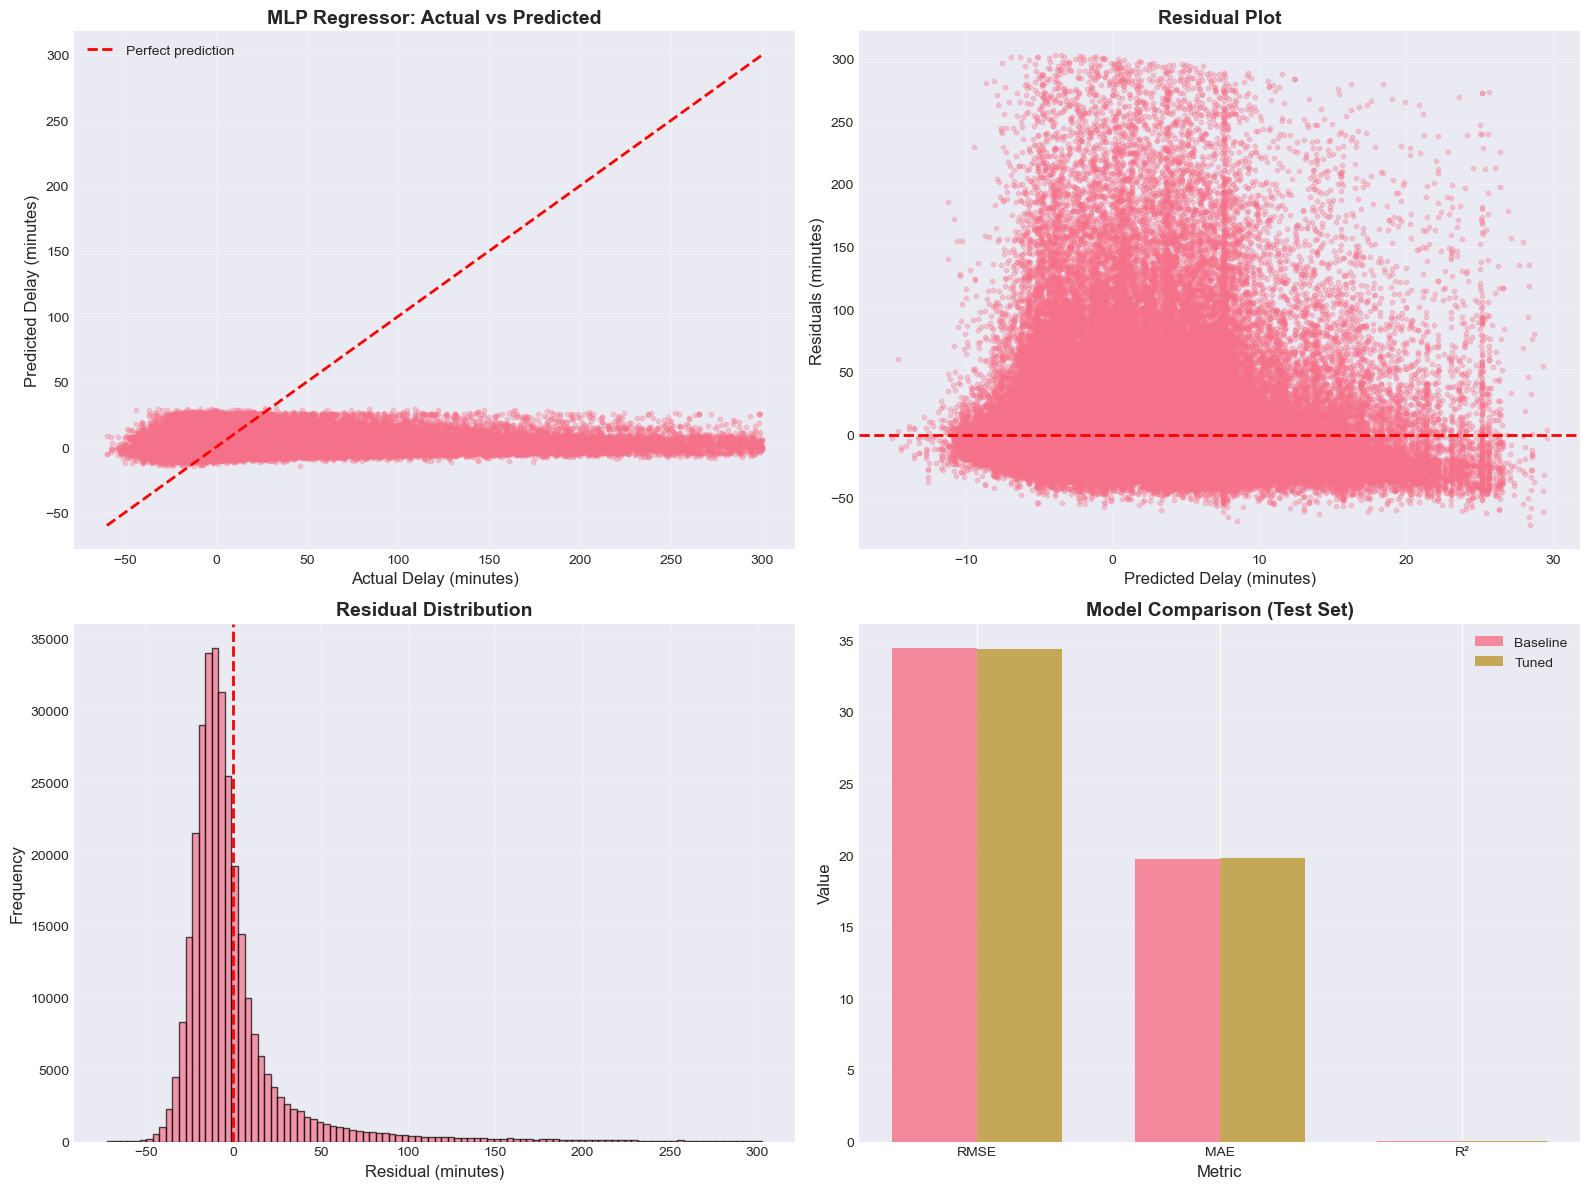

In [37]:
# Visualization of regressor performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

y_test_pred_reg = metrics_reg_final['y_test_pred']

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test_reg, y_test_pred_reg, alpha=0.3, s=10)
axes[0, 0].plot([y_test_reg.min(), y_test_reg.max()], 
                [y_test_reg.min(), y_test_reg.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual Delay (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Delay (minutes)', fontsize=12)
axes[0, 0].set_title('MLP Regressor: Actual vs Predicted', fontweight='bold', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Residual plot
residuals_reg = y_test_reg - y_test_pred_reg
axes[0, 1].scatter(y_test_pred_reg, residuals_reg, alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Delay (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Residuals (minutes)', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontweight='bold', fontsize=14)
axes[0, 1].grid(alpha=0.3)

# 3. Residual distribution
axes[1, 0].hist(residuals_reg, bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residual (minutes)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Residual Distribution', fontweight='bold', fontsize=14)
axes[1, 0].grid(alpha=0.3)

# 4. Error metrics comparison
metrics_names = ['RMSE', 'MAE', 'R²']
baseline_values = [
    metrics_reg_baseline['test_rmse'],
    metrics_reg_baseline['test_mae'],
    metrics_reg_baseline['test_r2']
]
tuned_values = [
    metrics_reg_tuned['test_rmse'],
    metrics_reg_tuned['test_mae'],
    metrics_reg_tuned['test_r2']
]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8)
axes[1, 1].bar(x + width/2, tuned_values, width, label='Tuned', alpha=0.8)
axes[1, 1].set_xlabel('Metric', fontsize=12)
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_title('Model Comparison (Test Set)', fontweight='bold', fontsize=14)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'mlp_regressor_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/figures/mlp_regressor_results.png")
plt.show()

### 1.9 Save MLP Regressor Model

In [38]:
# Save the best regressor model and scaler
save_model_reg(mlp_reg_final, '../results/mlp_regressor_model.joblib')
save_scaler(scaler_reg, '../results/mlp_regressor_scaler.joblib')

print("\n✓ MLP Regressor saved successfully!")


✓ Model saved to: ..\results\mlp_regressor_model.joblib
✓ Scaler saved to: ..\results\mlp_regressor_scaler.joblib

✓ MLP Regressor saved successfully!


---
## Part 2: MLP Classifier - Binary Delay Classification
---

### 2.1 Load Engineered Data (Classification)

In [39]:
# Load the classification dataset
input_path_clf = '../data/processed/flight_delays_engineered.csv'
df_clf = load_engineered_data(input_path_clf)

print(f"\nDataset shape: {df_clf.shape}")
print(f"\nFirst few rows:")
df_clf.head()


Dataset shape: (1527160, 19)

First few rows:


,Date (YYYY-MM-DD),Scheduled Elapsed Time (Minutes),IsWeekend,Is_Holiday_Period,Carrier_9E,Carrier_AA,Carrier_AS,Carrier_DL,Carrier_EV,Carrier_MQ,Carrier_NK,Carrier_OO,Carrier_UA,Carrier_WN,Carrier_YX,Origin_Airport_Encoded,Season_Encoded,Arrival Delay (Minutes),Is_Delayed
0,2019-01-01,83,0,1,1,0,0,0,0,0,0,0,0,0,0,67,3,-1,0
1,2019-01-01,72,0,1,1,0,0,0,0,0,0,0,0,0,0,163,3,-14,0
2,2019-01-01,85,0,1,1,0,0,0,0,0,0,0,0,0,0,86,3,9,0
3,2019-01-01,112,0,1,1,0,0,0,0,0,0,0,0,0,0,16,3,-7,0
4,2019-01-01,129,0,1,1,0,0,0,0,0,0,0,0,0,0,28,3,-32,0


In [5]:
# Define features for modeling
exclude_cols_clf = ['Date (YYYY-MM-DD)', 'Carrier Code', 'Origin Airport', 
                    'Season', 'Arrival Delay (Minutes)', 'Is_Delayed']

feature_cols_clf = [col for col in df_clf.columns if col not in exclude_cols_clf]

print(f"\nTotal features for classification: {len(feature_cols_clf)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols_clf, 1):
    print(f"  {i:2}. {col}")


Total features for classification: 16

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Carrier_DL
   8. Carrier_EV
   9. Carrier_MQ
  10. Carrier_NK
  11. Carrier_OO
  12. Carrier_UA
  13. Carrier_WN
  14. Carrier_YX
  15. Origin_Airport_Encoded
  16. Season_Encoded


In [6]:
# Check class distribution
print("CLASS DISTRIBUTION ANALYSIS:")

delayed_counts = df_clf['Is_Delayed'].value_counts()
delayed_pct = df_clf['Is_Delayed'].value_counts(normalize=True) * 100

print("\nIs_Delayed Distribution:")
print(f"  Class 0 (On-time):  {delayed_counts[0]:,} ({delayed_pct[0]:.2f}%)")
print(f"  Class 1 (Delayed):  {delayed_counts[1]:,} ({delayed_pct[1]:.2f}%)")
print(f"  Imbalance ratio: {delayed_counts[0] / delayed_counts[1]:.2f}:1")

CLASS DISTRIBUTION ANALYSIS:

Is_Delayed Distribution:
  Class 0 (On-time):  1,294,299 (84.75%)
  Class 1 (Delayed):  232,861 (15.25%)
  Imbalance ratio: 5.56:1


### 2.2 Prepare Data & Scale Features (Classification)

In [7]:
# Split data with stratification
print("PREPARING DATA FOR MLP CLASSIFIER")
print("="*60)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = prepare_data_classifier(
    df_clf,
    feature_cols_clf,
    'Is_Delayed',
    test_size=0.2,
    random_state=42
)

PREPARING DATA FOR MLP CLASSIFIER
  Training set: 1,221,728 samples
  Test set: 305,432 samples
  Feature dimensions: 16

  Training set class distribution:
    Class 0 (On-time): 1,035,439 (84.75%)
    Class 1 (Delayed): 186,289 (15.25%)


In [8]:
# Scale features (CRITICAL for MLP!)
X_train_clf_scaled, X_test_clf_scaled, scaler_clf = scale_features(
    X_train_clf,
    X_test_clf
)

print(f"\n✓ Features prepared and scaled for MLP Classifier")


SCALING FEATURES
  Mean (train): -0.000000
  Std Dev (train): 1.000000
  ✓ Features scaled successfully

✓ Features prepared and scaled for MLP Classifier


### 2.3 Train MLP Classifier (Baseline)

In [9]:
# Train baseline MLP classifier
print("\n" + "="*80)
print("BASELINE MLP CLASSIFIER")
print("="*80)

mlp_clf_baseline = train_mlp_classifier(
    X_train_clf_scaled,
    y_train_clf,
    hidden_layer_sizes=(50,),  # 1 hidden layer
    activation='relu',
    solver='adam',
    batch_size='auto',           # Faster batching
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=150,                # CRITICAL: Allow convergence!
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1        # More patience for early stopping
)


BASELINE MLP CLASSIFIER
TRAINING MLP CLASSIFIER

Model parameters:
  - hidden_layer_sizes: (50,)
  - activation: relu
  - solver: adam
  - alpha (L2 penalty): 0.001
  - learning_rate: constant
  - learning_rate_init: 0.001
  - max_iter: 150
  - early_stopping: True
  - validation_fraction: 0.1
Iteration 1, loss = 0.41881541
Validation score: 0.847429
Iteration 2, loss = 0.41732213
Validation score: 0.847520
Iteration 3, loss = 0.41713774
Validation score: 0.847520
Iteration 4, loss = 0.41703987
Validation score: 0.847454
Iteration 5, loss = 0.41692392
Validation score: 0.847520
Iteration 6, loss = 0.41687567
Validation score: 0.847421
Iteration 7, loss = 0.41681063
Validation score: 0.847520
Iteration 8, loss = 0.41675983
Validation score: 0.847520
Iteration 9, loss = 0.41673445
Validation score: 0.847520
Iteration 10, loss = 0.41667385
Validation score: 0.847331
Iteration 11, loss = 0.41665427
Validation score: 0.847520
Iteration 12, loss = 0.41663792
Validation score: 0.847520
Valid

### 2.4 Evaluate MLP Classifier (Baseline)

In [10]:
# Evaluate baseline classifier
print("\n" + "="*80)
print("BASELINE CLASSIFIER EVALUATION")
print("="*80)

metrics_clf_baseline = evaluate_classifier(
    mlp_clf_baseline,
    X_train_clf_scaled,
    y_train_clf,
    X_test_clf_scaled,
    y_test_clf
)


BASELINE CLASSIFIER EVALUATION
MLP CLASSIFICATION MODEL EVALUATION

Training Set Performance:
  Accuracy:  0.8475
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Test Set Performance:
  Accuracy:  0.8475
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.6079

Confusion Matrix (Test Set):
[[258860      0]
 [ 46572      0]]
  True Negatives:  258,860
  False Positives: 0
  False Negatives: 46,572
  True Positives:  0

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.85      1.00      0.92    258860
     Delayed       0.00      0.00      0.00     46572

    accuracy                           0.85    305432
   macro avg       0.42      0.50      0.46    305432
weighted avg       0.72      0.85      0.78    305432

Overfitting Analysis:
  Accuracy difference (train - test): -0.0000
  F1 difference (train - test): 0.0000
  Status: Good generalization ✓


### 2.5 Hyperparameter Tuning (MLP Classifier)

In [11]:
# Tune hyperparameters (this may take several minutes)
print("\n" + "="*80)
print("HYPERPARAMETER TUNING - MLP CLASSIFIER")
print("="*80)

mlp_clf_tuned, best_params_clf = tune_mlp_classifier_hyperparams(
    X_train_clf_scaled,
    y_train_clf,
    cv=3,
    n_jobs=-1,
    verbose=2
)


HYPERPARAMETER TUNING - MLP CLASSIFIER
STARTING HYPERPARAMETER TUNING (MLP CLASSIFIER)
Note: This may take several minutes...

Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Hyperparameter tuning complete in 2723.55 seconds

Best Parameters Found:
  - activation: relu
  - alpha: 0.0001
  - hidden_layer_sizes: (50, 100)
  - learning_rate_init: 0.001

Best F1 Score: 0.0012


### 2.6 Evaluate Tuned MLP Classifier

In [40]:
# Evaluate tuned classifier
print("\n" + "="*80)
print("TUNED CLASSIFIER EVALUATION")
print("="*80)

metrics_clf_tuned = evaluate_classifier(
    mlp_clf_tuned,
    X_train_clf_scaled,
    y_train_clf,
    X_test_clf_scaled,
    y_test_clf
)


TUNED CLASSIFIER EVALUATION
MLP CLASSIFICATION MODEL EVALUATION

Training Set Performance:
  Accuracy:  0.8475
  Precision: 0.5405
  Recall:    0.0001
  F1-Score:  0.0002

Test Set Performance:
  Accuracy:  0.8475
  Precision: 0.5000
  Recall:    0.0002
  F1-Score:  0.0003
  ROC-AUC:   0.6140

Confusion Matrix (Test Set):
[[258853      7]
 [ 46565      7]]
  True Negatives:  258,853
  False Positives: 7
  False Negatives: 46,565
  True Positives:  7

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.85      1.00      0.92    258860
     Delayed       0.50      0.00      0.00     46572

    accuracy                           0.85    305432
   macro avg       0.67      0.50      0.46    305432
weighted avg       0.79      0.85      0.78    305432

Overfitting Analysis:
  Accuracy difference (train - test): 0.0000
  F1 difference (train - test): -0.0001
  Status: Good generalization ✓


### 2.7 Compare Baseline vs Tuned (Classifier)

In [41]:
# Compare models
print("\n" + "="*80)
print("CLASSIFIER COMPARISON: BASELINE vs TUNED")
print("="*80)

comparison_clf = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [
        metrics_clf_baseline['test_accuracy'],
        metrics_clf_baseline['test_precision'],
        metrics_clf_baseline['test_recall'],
        metrics_clf_baseline['test_f1'],
        metrics_clf_baseline['test_roc_auc']
    ],
    'Tuned': [
        metrics_clf_tuned['test_accuracy'],
        metrics_clf_tuned['test_precision'],
        metrics_clf_tuned['test_recall'],
        metrics_clf_tuned['test_f1'],
        metrics_clf_tuned['test_roc_auc']
    ]
})

comparison_clf['Improvement'] = comparison_clf['Tuned'] - comparison_clf['Baseline']

print("\n", comparison_clf.to_string(index=False))

# Determine best model
if metrics_clf_tuned['test_f1'] > metrics_clf_baseline['test_f1']:
    print("\n✓ Tuned model performs better!")
    mlp_clf_final = mlp_clf_tuned
    metrics_clf_final = metrics_clf_tuned
else:
    print("\n✓ Baseline model performs better!")
    mlp_clf_final = mlp_clf_baseline
    metrics_clf_final = metrics_clf_baseline


CLASSIFIER COMPARISON: BASELINE vs TUNED

    Metric  Baseline    Tuned  Improvement
 Accuracy  0.847521 0.847521     0.000000
Precision  0.000000 0.500000     0.500000
   Recall  0.000000 0.000150     0.000150
 F1-Score  0.000000 0.000301     0.000301
  ROC-AUC  0.607874 0.613969     0.006094

✓ Tuned model performs better!


### 2.8 Visualize Classifier Results

✓ Saved: ../results/figures/mlp_classifier_results.png


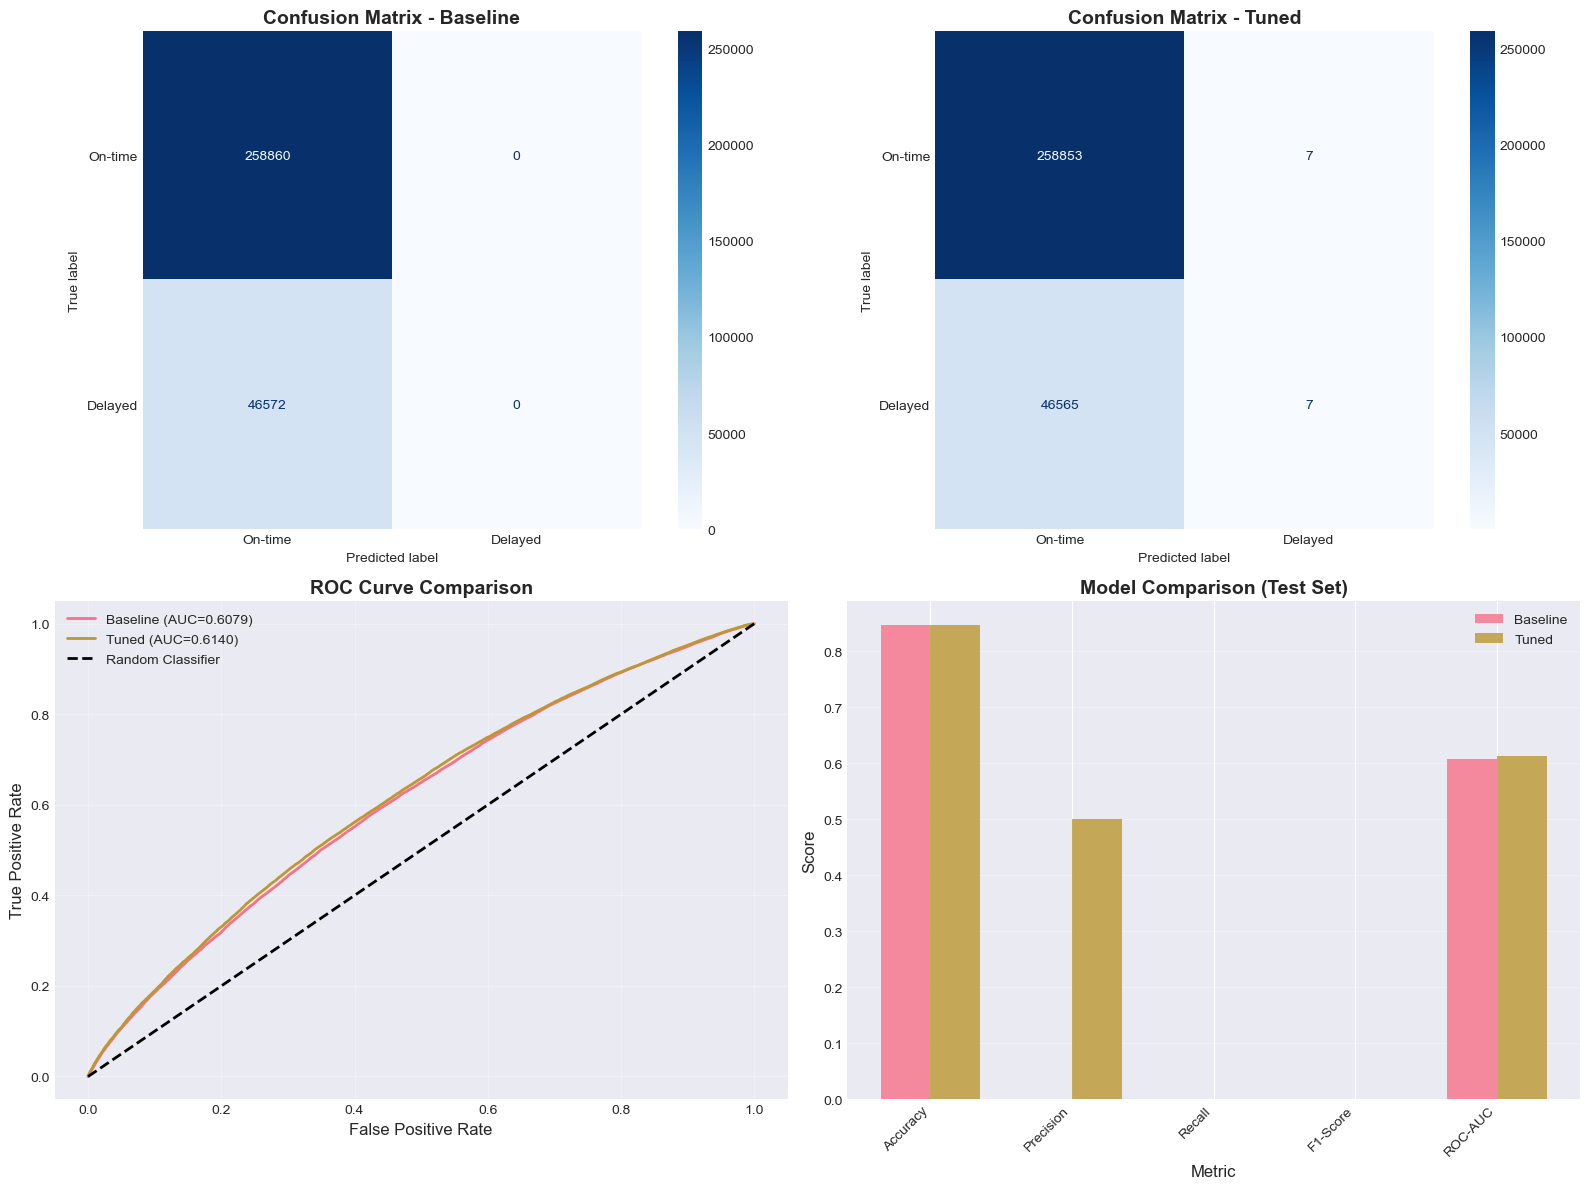

In [42]:
# Visualization of classifier performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix - Baseline
cm_baseline = metrics_clf_baseline['confusion_matrix']
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, 
                                        display_labels=['On-time', 'Delayed'])
disp_baseline.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title('Confusion Matrix - Baseline', fontweight='bold', fontsize=14)
axes[0, 0].grid(False)

# 2. Confusion Matrix - Tuned
cm_tuned = metrics_clf_tuned['confusion_matrix']
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned,
                                     display_labels=['On-time', 'Delayed'])
disp_tuned.plot(ax=axes[0, 1], cmap='Blues', values_format='d')
axes[0, 1].set_title('Confusion Matrix - Tuned', fontweight='bold', fontsize=14)
axes[0, 1].grid(False)

# 3. ROC Curve comparison
from sklearn.metrics import roc_curve

fpr_baseline, tpr_baseline, _ = roc_curve(y_test_clf, metrics_clf_baseline['y_test_proba'])
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_clf, metrics_clf_tuned['y_test_proba'])

axes[1, 0].plot(fpr_baseline, tpr_baseline, label=f"Baseline (AUC={metrics_clf_baseline['test_roc_auc']:.4f})", lw=2)
axes[1, 0].plot(fpr_tuned, tpr_tuned, label=f"Tuned (AUC={metrics_clf_tuned['test_roc_auc']:.4f})", lw=2)
axes[1, 0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 0].set_title('ROC Curve Comparison', fontweight='bold', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Metrics comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
baseline_values = [
    metrics_clf_baseline['test_accuracy'],
    metrics_clf_baseline['test_precision'],
    metrics_clf_baseline['test_recall'],
    metrics_clf_baseline['test_f1'],
    metrics_clf_baseline['test_roc_auc']
]
tuned_values = [
    metrics_clf_tuned['test_accuracy'],
    metrics_clf_tuned['test_precision'],
    metrics_clf_tuned['test_recall'],
    metrics_clf_tuned['test_f1'],
    metrics_clf_tuned['test_roc_auc']
]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8)
axes[1, 1].bar(x + width/2, tuned_values, width, label='Tuned', alpha=0.8)
axes[1, 1].set_xlabel('Metric', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Model Comparison (Test Set)', fontweight='bold', fontsize=14)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save figure
plt.savefig(figures_dir / 'mlp_classifier_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/figures/mlp_classifier_results.png")
plt.show()

### 2.9 Save MLP Classifier Model

In [21]:
# Save the best classifier model and scaler
save_model_clf(mlp_clf_final, '../results/mlp_classifier_model.joblib')
save_scaler(scaler_clf, '../results/mlp_classifier_scaler.joblib')

print("\n✓ MLP Classifier saved successfully!")


✓ Model saved to: ..\results\mlp_classifier_model.joblib
✓ Scaler saved to: ..\results\mlp_classifier_scaler.joblib

✓ MLP Classifier saved successfully!


---
## Part 3: Final Summary & Model Comparison
---

In [43]:
# Create comprehensive summary
print("\n" + "="*80)
print("MLP MODEL TRAINING SUMMARY")
print("="*80)

print("\n📊 REGRESSOR PERFORMANCE (Test Set):")
print(f"  RMSE: {metrics_reg_final['test_rmse']:.4f} minutes")
print(f"  MAE:  {metrics_reg_final['test_mae']:.4f} minutes")
print(f"  R²:   {metrics_reg_final['test_r2']:.4f}")

print("\n📈 CLASSIFIER PERFORMANCE (Test Set):")
print(f"  Accuracy:  {metrics_clf_final['test_accuracy']:.4f}")
print(f"  Precision: {metrics_clf_final['test_precision']:.4f}")
print(f"  Recall:    {metrics_clf_final['test_recall']:.4f}")
print(f"  F1-Score:  {metrics_clf_final['test_f1']:.4f}")
print(f"  ROC-AUC:   {metrics_clf_final['test_roc_auc']:.4f}")

print("\n💾 SAVED MODELS:")
print("  - mlp_regressor_model.joblib")
print("  - mlp_regressor_scaler.joblib")
print("  - mlp_classifier_model.joblib")
print("  - mlp_classifier_scaler.joblib")

print("\n✓ MLP model training complete!")


MLP MODEL TRAINING SUMMARY

📊 REGRESSOR PERFORMANCE (Test Set):
  RMSE: 34.3715 minutes
  MAE:  19.8030 minutes
  R²:   0.0247

📈 CLASSIFIER PERFORMANCE (Test Set):
  Accuracy:  0.8475
  Precision: 0.5000
  Recall:    0.0002
  F1-Score:  0.0003
  ROC-AUC:   0.6140

💾 SAVED MODELS:
  - mlp_regressor_model.joblib
  - mlp_regressor_scaler.joblib
  - mlp_classifier_model.joblib
  - mlp_classifier_scaler.joblib

✓ MLP model training complete!


In [44]:
# Save performance summary to CSV
summary_data = {
    'Model': ['MLP Regressor', 'MLP Classifier'],
    'Task': ['Regression', 'Binary Classification'],
    'Test_RMSE': [metrics_reg_final['test_rmse'], np.nan],
    'Test_MAE': [metrics_reg_final['test_mae'], np.nan],
    'Test_R2': [metrics_reg_final['test_r2'], np.nan],
    'Test_Accuracy': [np.nan, metrics_clf_final['test_accuracy']],
    'Test_Precision': [np.nan, metrics_clf_final['test_precision']],
    'Test_Recall': [np.nan, metrics_clf_final['test_recall']],
    'Test_F1': [np.nan, metrics_clf_final['test_f1']],
    'Test_ROC_AUC': [np.nan, metrics_clf_final['test_roc_auc']]
}

summary_df = pd.DataFrame(summary_data)
summary_path = Path('../results/model_performance_summary_mlp.csv')
summary_df.to_csv(summary_path, index=False)

print(f"\n✓ Performance summary saved to: {summary_path}")
print("\n", summary_df.to_string(index=False))


✓ Performance summary saved to: ..\results\model_performance_summary_mlp.csv

          Model                  Task  Test_RMSE  Test_MAE  Test_R2  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_ROC_AUC
 MLP Regressor            Regression  34.371487 19.803006 0.024659            NaN             NaN          NaN      NaN           NaN
MLP Classifier Binary Classification        NaN       NaN      NaN       0.847521             0.5      0.00015 0.000301      0.613969
